# Initialize   

In [1]:
import numpy as np
import random
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# SEIR Class

In [2]:
class SEIRModel:
    def __init__(self, population, beta, sigma, gamma):
        self.population = population
        self.beta = beta
        self.sigma = sigma
        self.gamma = gamma
        self.s = 100 
        self.e = 10
        self.i = 0
        self.r = 0

    def step(self):
        new_infections = self.beta * self.s * self.i / self.population
        new_exposed = new_infections
        new_recovered = self.gamma * self.i
        self.s -= new_infections
        self.e += new_exposed
        self.i += new_infections - new_recovered
        self.r += new_recovered

    def get_infected(self):
        return int(self.i)

    def __call__(self, y, t, N, beta, sigma, gamma):
        S, E, I, R = y
        dSdt = -beta * S * I / N
        dEdt = beta * S * I / N - sigma * E
        dIdt = sigma * E - gamma * I
        dRdt = gamma * I
        return dSdt, dEdt, dIdt, dRdt

# Load data

In [3]:
def load_df(data_name: str) -> pd.DataFrame:
  path = f"nb_datasets/{data_name}"

  df:pd.DataFrame = pd.read_csv(path)

  # ensure sort by date
  df['date'] = pd.to_datetime(df['date'], dayfirst=True, format='%d/%m/%Y')
  df_sorted: pd.DataFrame = df.sort_values(by='date')
  
  return df_sorted

# Split data

In [4]:
def load_observed(df: pd.DataFrame, brgy_name: str) -> pd.DataFrame:
  
  df_sorted: pd.DataFrame = df[df['barangay_Res'] == brgy_name]

  # keep relevant cols
  keep_cols = ["date", "count_Exposed", "count_Infectious", "count_Recovered"]
  main_df: pd.DataFrame = df_sorted[df_sorted.columns.intersection(keep_cols)]

  # Observed data (e.g., daily infections)
  # observed_data = main_df['count_Infectious'].to_numpy()

  # total_cases = main_df['count_Infectious'].sum()
  
  return main_df


# Sim Anneal Code

In [5]:
# Simulate SEIR model
def simulate_seir(beta, sigma, gamma, y0, t, n):
    N = n
    seir_model = SEIRModel(N, beta, sigma, gamma)
    
    # Solve ODEs for SEIR
    result = odeint(seir_model, y0, t, args=(N, beta, sigma, gamma))
    S, E, I, R = result.T
    
    return E, I, R
      

# Objective function
def objective_function(params, observed_data, initial_conditions, time_points, n):
    beta, sigma, gamma = params

    # Simulate the SEIR model with given parameters
    predicted_E, predicted_I, predicted_R = simulate_seir(beta, sigma, gamma, initial_conditions, time_points, n)
    
    # Split observed data into compartments
    observed_E, observed_I, observed_R = observed_data[:, 0], observed_data[:, 1], observed_data[:, 2]
    
    # Calculate metrics for each compartment
    metrics = {}
    r2_dict= {}
    mae_dict = {}
    rmse_dict = {}
    
    for compartment, observed, predicted in zip(
        ["E", "I", "R"],
        [observed_E, observed_I, observed_R],
        [predicted_E, predicted_I, predicted_R]
        ):
    
        r2 = r2_score(observed, predicted)
        mae = mean_absolute_error(observed, predicted)
        rmse = np.sqrt(mean_squared_error(observed, predicted))

        # Normalize metrics
        r2_normalized = 1 - r2  # Invert R^2 for minimization
        mae_normalized = mae / np.max(observed)  # Scale by max value
        rmse_normalized = rmse / np.max(observed)  # Scale by max value

        # Weighted average for each compartment
        combined_metric = (0.6 * r2_normalized) + (0.2 * mae_normalized) + (0.2 * rmse_normalized)
        metrics[compartment] = combined_metric
        r2_dict[compartment] = r2
        mae_dict[compartment] = mae
        rmse_dict[compartment] = rmse

    # Combine all compartments (average or weighted sum)
    total_metric = np.mean(list(metrics.values()))  # Equal weight to all compartments
    total_r2 = np.mean(list(r2_dict.values()))
    total_mae = np.mean(list(mae_dict.values()))
    total_rmse = np.mean(list(rmse_dict.values()))
    
    return total_metric, total_r2, total_mae, total_rmse



# Simulated Annealing for SEIR parameter tuning
def simulated_annealing_seir(observed_data, initial_conditions, time_points, temp, cooling_rate, max_iter, n):
    # Initial parameter guesses
    current_params = [0.3, 0.2, 0.1]  # Initial guesses for beta, sigma, gamma
    current_cost, current_r2, current_mae, current_rmse = objective_function(current_params, observed_data, initial_conditions, time_points, n)
    best_params = current_params
    best_r2, best_mae, best_rmse = current_r2, current_mae, current_rmse
    best_cost = current_cost

    cost_list = []
    
    min_temp = 1e-5 
    initial_temp = temp
    
    for i in range(max_iter):
        # Generate new candidate parameters
        new_params = [param + random.uniform(-0.01, 0.01) for param in current_params]
        new_params = np.clip(new_params, 0, 1)  # Keep parameters in a valid range (0 to 1)        
        
        # Evaluate the new candidate solution
        new_cost, new_r2, new_mae, new_rmse = objective_function(new_params, observed_data, initial_conditions, time_points, n)

        # ADJUST BASED ON METRIC
        # Decide whether to accept the new solution
        if new_cost < current_cost or random.random() < np.exp((current_cost - new_cost) / temp):
            current_params = new_params
            current_cost = new_cost
            
            # Update the best solution found so far
            if new_cost < best_cost:
                best_params = new_params
                best_cost = new_cost
                best_r2, best_mae, best_rmse = new_r2, new_mae, new_rmse
                
                
                
                

        # log for visualizing progress
        cost_list.append(best_cost) 

        # Cool down the temperature
        #temp = max(temp * cooling_rate, min_temp)  # Exponential decrease
        #temp = temp - (initial_temp / max_iter)  # Linear decrease
        temp = initial_temp / (1 + cooling_rate * i)  # Logarithmic decrease

    return best_params, best_cost, cost_list, temp, best_r2, best_mae, best_rmse

# Run Sim Anneal

In [6]:
brgy_name = "LANDAYAN"
main_df: pd.DataFrame = load_df("CITY_OF_SAN_PEDRO_processed.csv")
main_observed: pd.DataFrame = load_observed(main_df, brgy_name) # Change to check for other Brgys.

train_data = main_observed[(main_observed['date'] >= '09/01/2020') & (main_observed['date'] <= '12/31/2021')]
test_data = main_observed[(main_observed['date'] > '01/01/2022') & (main_observed['date'] <= '12/31/2022')]

df_observed_data = main_observed[(main_observed['date'] >= '09/01/2020') & (main_observed['date'] <= '12/31/2022')]

Final Temp = 1.052576180201042 
Best Cost = 0.904 

Prameters: 
beta: 0.253 
sigma: 0.109 
gamma:0.205

Metrics: 
best r2: -0.344 
best mae: 74.186 
best rmse: 95.089


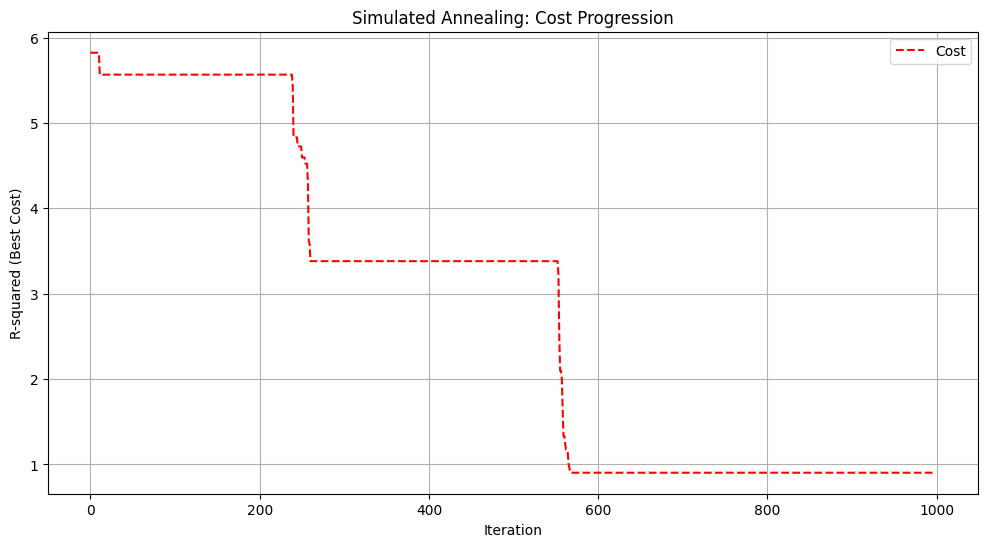

In [8]:
# Initial parameters
N = df_observed_data[['count_Exposed', 'count_Infectious', 'count_Recovered']].max().max()
I0 = train_data['count_Infectious'].iloc[0] # Initial infected from data
E0 = train_data['count_Exposed'].iloc[0] # Initial exposed cases
R0 = train_data['count_Recovered'].iloc[0] # Initial recovered
S0 = N - I0 - E0 - R0  # Susceptible

initial_conditions: tuple = [S0, E0, I0, R0]

# Simulated Annealing parameters
temp = 1000  
cooling_rate = 0.95
max_iter = 1000  

observed_data = train_data[["count_Exposed", "count_Infectious", "count_Recovered"]].to_numpy()

time_points = np.arange(train_data.shape[0]) # odeint expects an array (vector) of integers.

# Run the Simulated Annealing algorithm
best_params, best_cost, cost_list, final_temp, best_r2, best_mae, best_rmse = simulated_annealing_seir(observed_data, initial_conditions, time_points, temp, cooling_rate, max_iter, N)
o_beta, o_sigma, o_gamma = best_params

print(f"Final Temp = {final_temp} \nBest Cost = {best_cost:.3f} \n\nPrameters: \nbeta: {o_beta:.3f} \nsigma: {o_sigma:.3f} \ngamma:{o_gamma:.3f}\n")
print(f"Metrics: \nbest r2: {best_r2:.3f} \nbest mae: {best_mae:.3f} \nbest rmse: {best_rmse:.3f}")

# Plot cost progression each compartment
plt.figure(figsize=(12, 6))
plt.plot(cost_list, 'r--', label='Cost')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("R-squared (Best Cost)")
plt.title(f"Simulated Annealing: Cost Progression")
plt.grid(True)
plt.show()


# Plot

1480


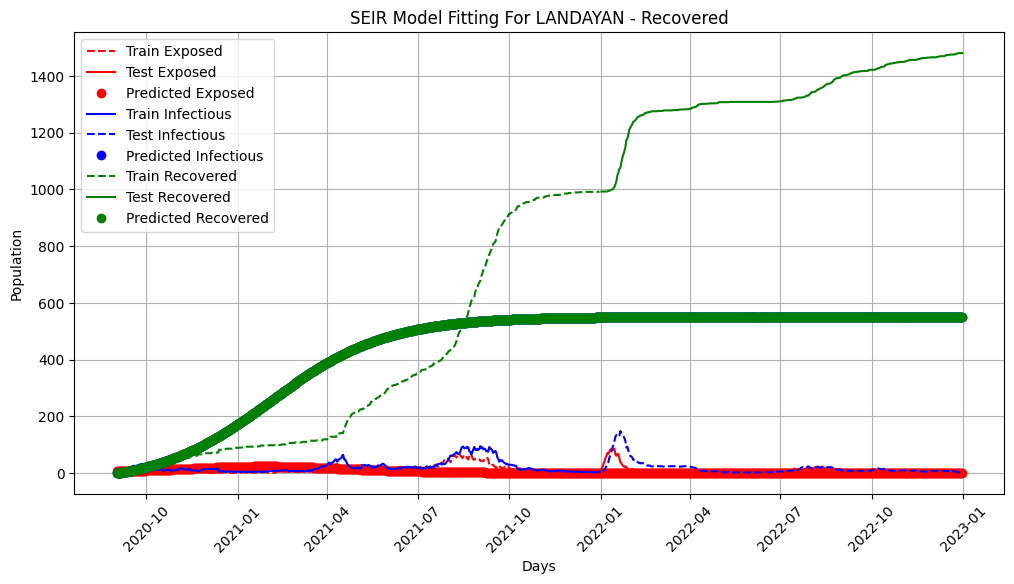

In [11]:
'''
Final Temp = 1.052576180201042 
Best Cost = 0.904 

Prameters: 
beta: 0.253 
sigma: 0.109 
gamma:0.205

Metrics: 
best r2: -0.344 
best mae: 74.186 
best rmse: 95.089
'''

o_beta, o_sigma, o_gamma = 0.253 , 0.109, 0.205 # from best params

observed_main = df_observed_data.copy()

I0 = observed_main['count_Infectious'].iloc[0] # Initial infected from data
E0 = observed_main['count_Exposed'].iloc[0] # Initial exposed cases
R0 = observed_main['count_Recovered'].iloc[0] # Initial recovered
S0 = N - I0 - E0 - R0  # Susceptible

initial_conditions: tuple = [S0, E0, I0, R0]

time_points = np.arange(observed_main.shape[0]) # odeint expects an array (vector) of integers.

# for plotting
plot_actual = pd.DataFrame({
    'date_train': train_data['date'],
    'date_test': test_data['date'],
    'train_exposed': train_data['count_Exposed'],
    'test_exposed': test_data['count_Exposed'],
    'train_infectious': train_data['count_Infectious'],
    'test_infectious': test_data['count_Infectious'],
    'train_recovered': train_data['count_Recovered'],
    'test_recovered': test_data['count_Recovered']
})

# simulate with the optimized paramaters
e, i, r = simulate_seir(o_beta, o_sigma, o_gamma, initial_conditions, time_points, N)

plot_prediction = pd.DataFrame({
    'date': observed_main['date'],
    'E': e,
    'I': i,
    'R': r
})


plt.figure(figsize=(12, 6))
# Exposed
plt.plot(plot_actual['date_train'], plot_actual['train_exposed'], 'r--', label='Train Exposed')
plt.plot(plot_actual['date_test'], plot_actual['test_exposed'], 'r-', label='Test Exposed')
plt.plot(plot_prediction['date'], plot_prediction['E'], 'ro', label='Predicted Exposed')
# Infectious
plt.plot(plot_actual['date_train'], plot_actual['train_infectious'], 'b-', label='Train Infectious')
plt.plot(plot_actual['date_test'], plot_actual['test_infectious'], 'b--', label='Test Infectious')
plt.plot(plot_prediction['date'], plot_prediction['R'], 'bo', label='Predicted Infectious')
# Recovered
plt.plot(plot_actual['date_train'], plot_actual['train_recovered'], 'g--', label='Train Recovered')
plt.plot(plot_actual['date_test'], plot_actual['test_recovered'], 'g-', label='Test Recovered')
plt.plot(plot_prediction['date'], plot_prediction['R'], 'go', label='Predicted Recovered')
plt.xlabel('Days')
plt.ylabel('Population')
plt.legend()
plt.xticks(rotation=45)
plt.title(f'SEIR Model Fitting For {brgy_name} - Recovered')
plt.grid(True)
plt.show()

In [159]:
rec_max = df_observed_data[df_observed_data['count_Recovered']==df_observed_data['count_Recovered']].max()
print(rec_max)

rec_sum = main_observed['count_Recovered'].sum()
print(rec_sum)

date                2022-12-31 00:00:00
count_Exposed                        86
count_Infectious                    148
count_Recovered                    1480
dtype: object
1227791


# For Different Metrics

1. R-2
if new_cost > current_cost or random.random() < np.exp((new_cost - current_cost) / temp):
            current_params = new_params
            current_cost = new_cost

            # Update the best solution found so far
            if new_cost > best_cost:
                best_params = new_params
                best_cost = new_cost